In this notebook, we strengthen the fundamental understanding of Convolutional Neural Network (CNN) by using built-in CNN architectures in Gluon to train a multiclass classification model on a real-world dataset.



In [1]:
! pip list | egrep mxnet

In [2]:
! pip list | egrep d2l

In [3]:
! pip install -q -U mxnet-cu101mkl==1.6.0.post0
! pip install -q d2l==0.14.0

     |████████████████████████████████| 712.3MB 26kB/s 
     |████████████████████████████████| 51kB 2.6MB/s 


In [4]:
!git clone "https://github.com/Ravikiran-Bhonagiri/aws-machine-learning-university-accelerated-cv.git"

Cloning into 'aws-machine-learning-university-accelerated-cv'...
remote: Enumerating objects: 14, done.
remote: Counting objects: 100% (14/14), done.
remote: Compressing objects: 100% (13/13), done.
remote: Total 2962 (delta 4), reused 6 (delta 1), pack-reused 2948
Receiving objects: 100% (2962/2962), 180.36 MiB | 39.49 MiB/s, done.
Resolving deltas: 100% (15/15), done.
Checking out files: 100% (3043/3043), done.


In [5]:
import os
from d2l import mxnet as d2l
import numpy as np
from mxnet import gluon, init, nd, autograd
from mxnet.gluon import nn
from mxnet.gluon.data.vision import transforms
from mxnet.gluon.loss import SoftmaxCrossEntropyLoss
from sklearn.metrics import accuracy_score

In [6]:
def comp_conv2d(conv2d, X):
    conv2d.initialize()
    # Add batch and channel dimension.
    X = X.reshape((1, 1) + X.shape)
    Y = conv2d(X)
    # Exclude the first two dimensions
    return Y.reshape(Y.shape[2:])

In [7]:
X = nd.random.uniform(shape=(3, 3))
conv2d = nn.Conv2D(channels=1, kernel_size=2, padding=1, strides=(2,3))
comp_conv2d(conv2d, X).shape

(2, 2)

In [8]:
X = nd.arange(16).reshape((1, 1, 4, 4))
print(X)
pool2d = nn.MaxPool2D(pool_size=3, padding=1, strides=2)
pool2d(X)


[[[[ 0.  1.  2.  3.]
   [ 4.  5.  6.  7.]
   [ 8.  9. 10. 11.]
   [12. 13. 14. 15.]]]]
<NDArray 1x1x4x4 @cpu(0)>



[[[[ 5.  7.]
   [13. 15.]]]]
<NDArray 1x1x2x2 @cpu(0)>

In [9]:
path = '/content/aws-machine-learning-university-accelerated-cv/data/minc-2500'
train_path = os.path.join(path, 'train')
val_path = os.path.join(path, 'val')
test_path = os.path.join(path, 'test')

In [10]:
def show_images(imgs, num_rows, num_cols, titles=None, scale=1.5):
    """Plot a list of images."""
    figsize = (num_cols * scale, num_rows * scale)
    _, axes = d2l.plt.subplots(num_rows, num_cols, figsize=figsize)
    axes = axes.flatten()
    for i, (ax, img) in enumerate(zip(axes, imgs)):
        ax.imshow(img.asnumpy())
        ax.axes.get_xaxis().set_visible(False)
        ax.axes.get_yaxis().set_visible(False)
        if titles:
            ax.set_title(titles[i])
    return axes

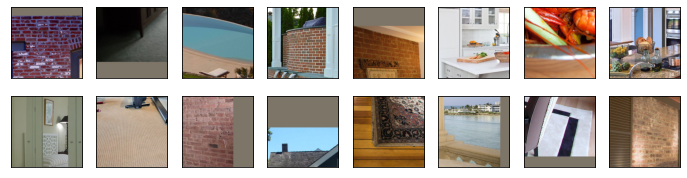

In [11]:
test_sample = gluon.data.DataLoader(gluon.data.vision.ImageFolderDataset(test_path),
                                    batch_size=2*8, shuffle=True)

for data, label in test_sample:
    show_images(data, 2, 8);
    break

In [12]:
transformation = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize()
])

In [13]:
batch_size = 16

train_loader = gluon.data.DataLoader(
    gluon.data.vision.ImageFolderDataset(train_path).transform_first(transformation),
    batch_size=batch_size, shuffle=True)

validation_loader = gluon.data.DataLoader(
    gluon.data.vision.ImageFolderDataset(val_path).transform_first(transformation),
    batch_size=batch_size, shuffle=False)

test_data = gluon.data.DataLoader(
    gluon.data.vision.ImageFolderDataset(test_path).transform_first(transformation),
    batch_size=batch_size, shuffle=False)

In [14]:
out_classes = 6

net = gluon.nn.Sequential()
net.add(gluon.nn.Conv2D(channels=20, kernel_size=5, activation='relu'))
net.add(gluon.nn.MaxPool2D(pool_size=2, strides=2))

# The Flatten layer collapses all axis, except the first one, into one axis.
net.add(gluon.nn.Flatten())
net.add(gluon.nn.Dense(128, activation='relu'))
net.add(gluon.nn.Dense(out_classes))

In [15]:
ctx = d2l.try_gpu() # Set this to CPU or GPU 

epochs = 10
learning_rate = 0.01
softmax_cross_entropy_loss = gluon.loss.SoftmaxCrossEntropyLoss()

In [16]:
net.collect_params().initialize(init.Xavier(magnitude=2.24), ctx=ctx)

trainer = gluon.Trainer(net.collect_params(), 'sgd', {'learning_rate': learning_rate})

In [17]:
for epoch in range(epochs):
    
    train_loss, val_loss, train_acc, valid_acc = 0., 0., 0., 0.
    
    # Training loop: (with autograd and trainer steps, etc.)
    # This loop does the training of the neural network (weights are updated)
    for i, (data, label) in enumerate(train_loader):
        data = data.as_in_context(ctx)
        label = label.as_in_context(ctx)
        with autograd.record():
            output = net(data)
            loss = softmax_cross_entropy_loss(output, label)
        loss.backward()
        train_acc += (output.argmax(axis=1) == label.astype('float32')).mean()
        train_loss += loss.mean()
        trainer.step(data.shape[0])
    
    # Validation loop:
    # This loop tests the trained network on validation dataset
    # No weight updates here
    for i, (data, label) in enumerate(validation_loader):
        data = data.as_in_context(ctx)
        label = label.as_in_context(ctx)
        output = net(data)
        valid_acc += (output.argmax(axis=1) == label.astype('float32')).mean()
        val_loss += softmax_cross_entropy_loss(output, label).mean()
        
    # Take averages
    train_loss /= len(train_loader)
    train_acc /= len(train_loader)
    val_loss /= len(validation_loader)
    valid_acc /= len(validation_loader)
    
    print("Epoch %d: train loss %.3f, train acc %.3f, val loss %.3f, val acc %.3f" % (
        epoch, train_loss.asnumpy()[0], train_acc.asnumpy()[0], val_loss.asnumpy()[0], valid_acc.asnumpy()[0]))


Epoch 0: train loss 1.652, train acc 0.319, val loss 1.399, val acc 0.510
Epoch 1: train loss 1.387, train acc 0.433, val loss 1.290, val acc 0.490
Epoch 2: train loss 1.255, train acc 0.528, val loss 1.266, val acc 0.500
Epoch 3: train loss 1.105, train acc 0.597, val loss 1.164, val acc 0.526
Epoch 4: train loss 1.053, train acc 0.617, val loss 1.104, val acc 0.594
Epoch 5: train loss 0.886, train acc 0.687, val loss 1.148, val acc 0.547
Epoch 6: train loss 0.793, train acc 0.727, val loss 1.205, val acc 0.589
Epoch 7: train loss 0.745, train acc 0.733, val loss 1.077, val acc 0.604
Epoch 8: train loss 0.595, train acc 0.806, val loss 0.969, val acc 0.656
Epoch 9: train loss 0.500, train acc 0.831, val loss 1.111, val acc 0.641
